In [1]:
import pandas as pd
import seaborn as sns

In [2]:
learning_curves = pd.read_csv('loss.csv', index_col=0, header=[0,1])
learning_curves

training               testing            validation          
            loss     auroc        loss     auroc        loss     auroc
0     258.503304  0.488724  264.063856  0.461526  264.786261  0.470801
1     180.001950  0.494054  174.030836  0.502585  185.673170  0.509641
2      26.941337  0.472341   23.914067  0.546395   24.447716  0.506706
3       2.668938  0.550237    2.646029  0.522861    2.663764  0.535890
4       2.594783  0.476003    2.587240  0.489410    2.553857  0.592813
...          ...       ...         ...       ...         ...       ...
9995  185.685325  0.514706  190.462763  0.478684  189.399656  0.464159
9996  215.321811  0.511900  222.609381  0.490867  228.837632  0.497172
9997  205.625922  0.511493  212.941237  0.482681  208.875207  0.490123
9998  207.638270  0.481731  208.348852  0.528460  204.006309  0.481330
9999  227.761813  0.474869  220.917455  0.515408  221.534305  0.449457

[10000 rows x 6 columns]

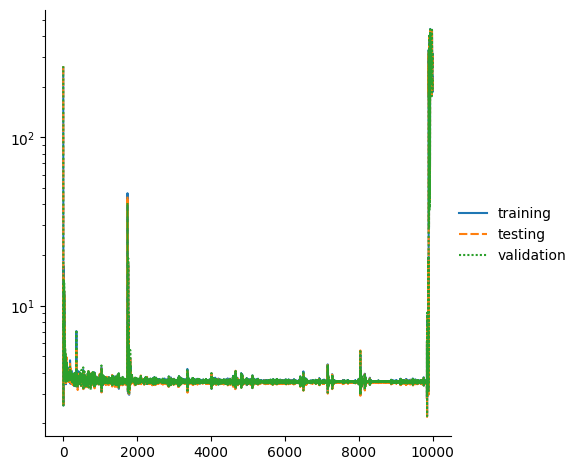

In [22]:
loss_g = sns.relplot(learning_curves.loc[:, (slice(None), 'loss')], kind='line', estimator=None)
loss_g.set(yscale = 'log')
#loss_g.set(xlim = (0, 10000))

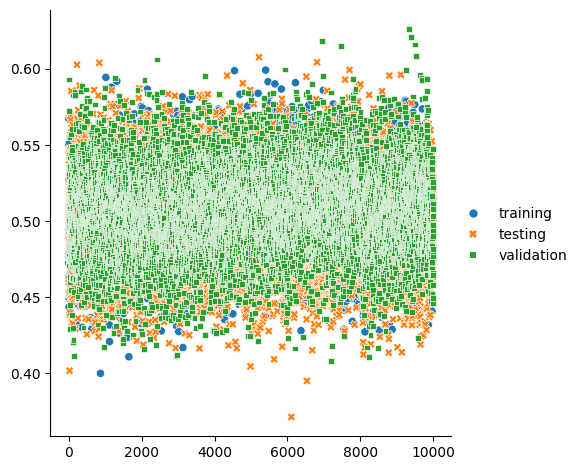

In [4]:
sns.relplot(learning_curves.loc[:, (slice(None), 'auroc')])

In [6]:
import sys
sys.path.append('..')

from train_nnc import NNConvNet
import torch

saved = torch.load('model.pt', map_location=torch.device('cpu'))
saved.keys()

dict_keys(['hyperparameters', 'parameters', 'best_epoch'])

In [7]:
saved['best_epoch']

9338

In [8]:
learning_curves.loc[saved['best_epoch']]

training    loss     3.528720
            auroc    0.538878
testing     loss     3.499687
            auroc    0.486953
validation  loss     3.517545
            auroc    0.625997
Name: 9338, dtype: float64

In [9]:
learning_curves.loc[:, (slice(None), 'auroc')].max(axis='index')

training    auroc    0.598972
testing     auroc    0.607449
validation  auroc    0.625997
dtype: float64

In [10]:
learning_curves.loc[:, (slice(None), 'loss')].min(axis='index')

training    loss    2.208671
testing     loss    2.186207
validation  loss    2.211876
dtype: float64

In [11]:
model = NNConvNet(**saved['hyperparameters'])
model.load_state_dict(saved['parameters'])
model.eval()

NNConvNet(
  (lin_in): Linear(in_features=18949, out_features=10, bias=True)
  (encoder): ModuleList(
    (0-1): 2 x Linear(in_features=10, out_features=10, bias=True)
  )
  (edge_nn): Sequential(
    (0): Linear(in_features=8, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (nnconv): ModuleList(
    (0-1): 2 x NNConv(10, 10, aggr=add, nn=Sequential(
      (0): Linear(in_features=8, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    ))
  )
  (decoder): ModuleList(
    (0-1): 2 x Linear(in_features=10, out_features=10, bias=True)
  )
  (lin_out): Linear(in_features=10, out_features=1, bias=True)
)

In [12]:
data = torch.load('../data/cpg0016_v1.pt', map_location=torch.device('cpu'))

In [13]:
with torch.no_grad():
    predict_df = pd.DataFrame({
        'y_hat': torch.softmax(model(data), dim=1)[:, 1],
        'y': data.y[:, 0]
    })
    predict_df['subset'] = 'Neither'
    predict_df['subset'][data.train_mask.numpy()] = 'Training'
    predict_df['subset'][data.test_mask.numpy()] = 'Testing'
    predict_df['subset'][data.val_mask.numpy()] = 'Validation'

/tmp/ipykernel_4032384/2688595686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['subset'][data.train_mask.numpy()] = 'Training'
/tmp/ipykernel_4032384/2688595686.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['subset'][data.test_mask.numpy()] = 'Testing'
/tmp/ipykernel_4032384/2688595686.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['subset'][data.val_mask.numpy()] = 'Validation'


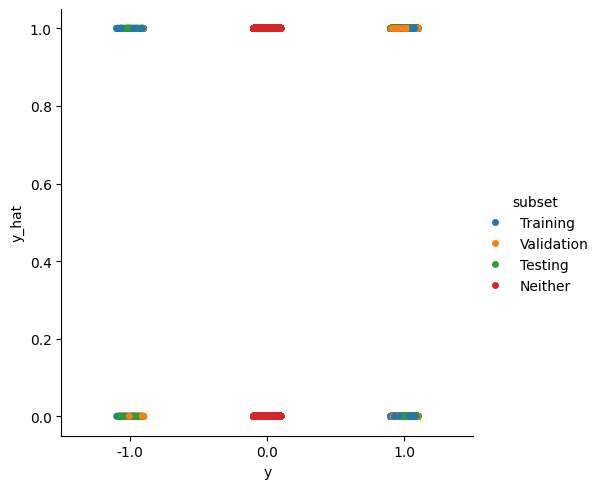

In [14]:
sns.catplot(predict_df, x='y', y='y_hat', hue='subset', kind='strip')

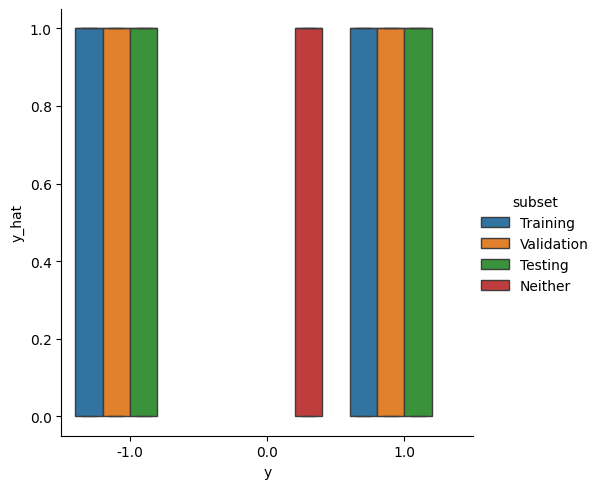

In [15]:
sns.catplot(predict_df, x='y', y='y_hat', hue='subset', kind='box')

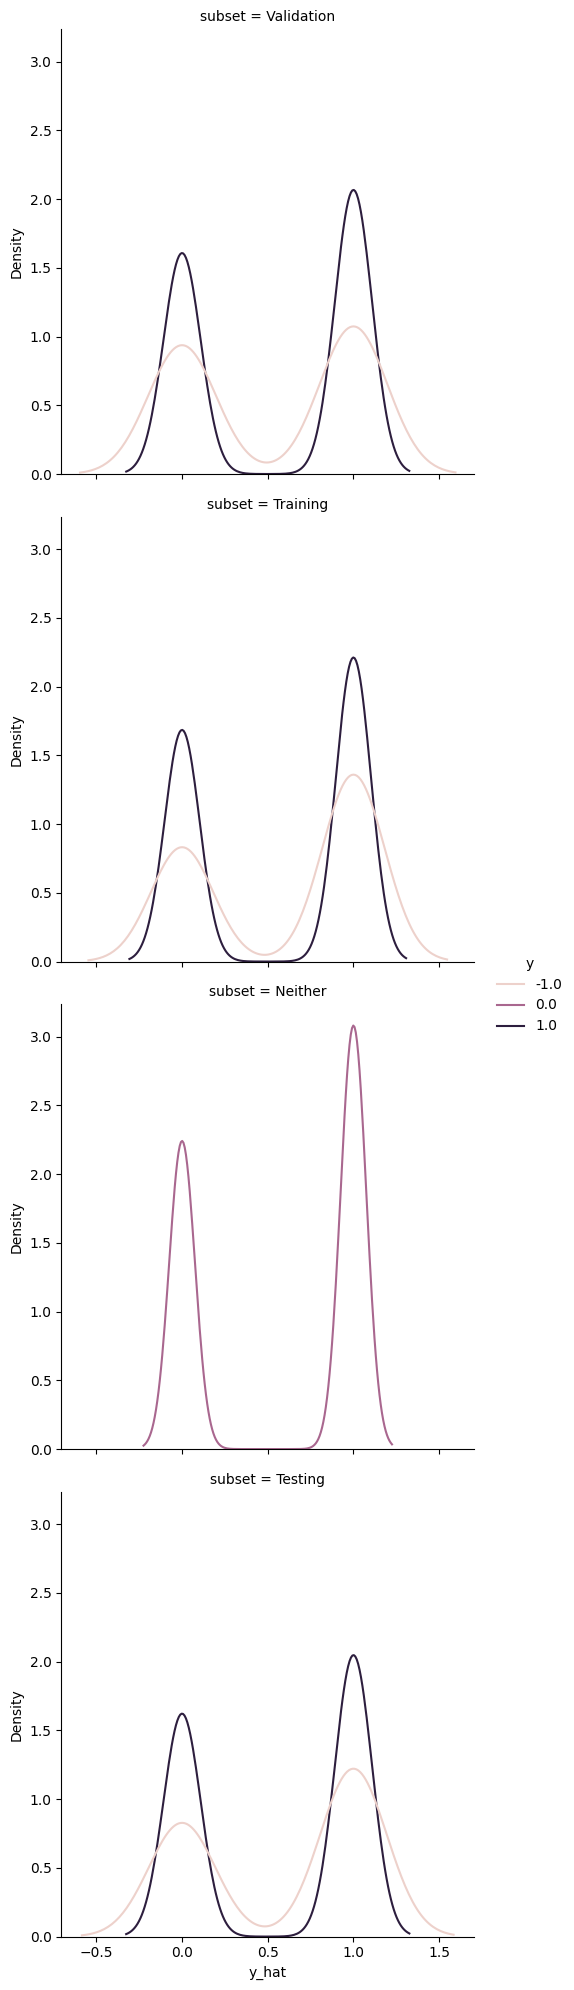

In [23]:
sns.displot(
    predict_df,
    x='y_hat',
    hue='y',
    row='subset',
    kind='kde',
    common_norm=False
)

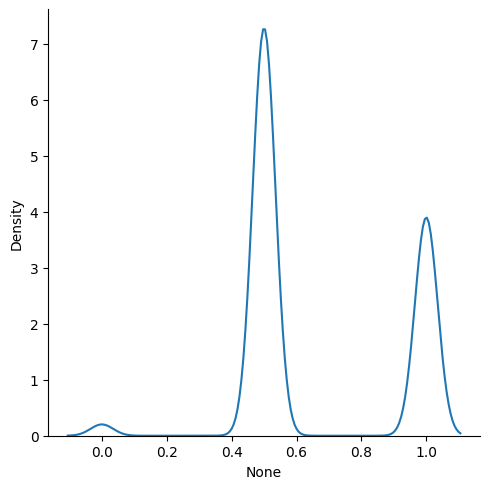

In [ ]:
# Verify that data preprocessing isn't screwing this up
y_float = (data.y + 1) * 0.5
sns.displot(x=pd.Series(y_float[:,0].numpy()), kind='kde')

In [ ]:
y_int = torch.tensor(y_float, dtype=torch.int64)
pd.Series(y_int[:,0].numpy()).value_counts()

/tmp/ipykernel_2538/4268706411.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_int = torch.tensor(y_float, dtype=torch.int64)


0    12746
1     6639
Name: count, dtype: int64

In [ ]:
for mask in (data.train_mask, data.test_mask, data.val_mask):
    print(pd.Series(y_int[mask,0].numpy()).value_counts())

1    2656
0     137
Name: count, dtype: int64
1    1992
0     104
Name: count, dtype: int64
1    1993
0     103
Name: count, dtype: int64
